In [4]:
# -*- coding: utf-8 -*-
"""
Multi-step geospatial processing with recursive sub-graphs.

Implements Option 3: Recursive Sub-Graph architecture for handling complex,
multi-step geoprocessing workflows.

Workflow:
1. Decompose: Break multi-step query into ordered subtasks
2. For each task:
   a. Analyze: Identify dependencies and inject outputs from previous tasks
   b. Execute: Run single-task sub-graph
   c. Store: Save results for potential use in later tasks
3. Finalize: Summarize all tasks and results
"""
import json
from typing import List, Dict, Any, Optional

from langgraph.graph import StateGraph, END
from langgraph.types import RetryPolicy
from langchain_core.messages import (
    BaseMessage,
    AIMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)


# from ..tools import (
#     find_processing_algorithm,
#     get_algorithm_parameters,
#     execute_processing,
#     list_qgis_layers,
#     TOOLS,
# )

def find_processing_algorithm():
    pass

def get_algorithm_parameters():
    pass

def execute_processing():
    pass

def list_qgis_layers():
    pass

TOOLS = {}

# from ..prompts.system import (
#     PROCESSING_ROUTING_PROMPT,
#     PROCESSING_ALGORITHM_SELECTION_PROMPT,
#     PROCESSING_PARAMETER_GATHERING_PROMPT,
#     TASK_DECOMPOSITION_PROMPT,
#     DEPENDENCY_ANALYSIS_PROMPT,
#     MULTI_STEP_ERROR_ANALYSIS_PROMPT,
# )

PROCESSING_ALGORITHM_SELECTION_PROMPT = ''
PROCESSING_PARAMETER_GATHERING_PROMPT = ''
TASK_DECOMPOSITION_PROMPT = ''
DEPENDENCY_ANALYSIS_PROMPT = ''
MULTI_STEP_ERROR_ANALYSIS_PROMPT = ''

class ProcessingState():
    pass

# from ..agents.schemas import (
#     RouteDecision,
#     AlgorithmSelection,
#     ParameterGathering,
#     TaskDecomposition,
#     DependencyInjection,
#     TaskResult,
#     ErrorAnalysis,
# )

def AlgorithmSelection():
    pass

def ParameterGathering():
    pass

def TaskDecomposition():
    pass

def DependencyInjection():
    pass

def ErrorAnalysis():
    pass

# from ..logger.processing_logger import get_processing_logger

# _logger = get_processing_logger()
import logging
_logger = logging.getLogger("processing_logger")


def decompose_tasks_node(state: ProcessingState) -> ProcessingState:
    """
    Decompose a multi-step query into ordered, executable subtasks.
    
    Uses LLM with structured output to identify task boundaries and dependencies.
    """
    _logger.info("=" * 80)
    _logger.info("NODE: decompose_tasks_node START")
    
    if not state.get("is_processing_task"):
        _logger.info("Not a processing task, skipping decomposition")
        return state
    
    query = state["user_query"]
    _logger.debug(f"Decomposing query: {query}")
    
    messages = [
        SystemMessage(content=TASK_DECOMPOSITION_PROMPT),
        HumanMessage(content=f"User query: {query}"),
    ]
    
    try:
        structured_llm = llm.with_structured_output(TaskDecomposition)
        decomposition: TaskDecomposition = structured_llm.invoke(messages)
        
        tasks = [task.model_dump() for task in decomposition.tasks]
        total_steps = decomposition.total_steps
        
        is_multi_step = total_steps > 1
        
        _logger.info(
            f"Decomposed into {total_steps} task(s), multi_step={is_multi_step}"
        )
        for i, task in enumerate(tasks, 1):
            _logger.debug(f"  Task {i}: {task['operation']}")
            _logger.debug(f"    - Algorithm hint: {task['algorithm_hint']}")
            _logger.debug(f"    - Dependencies: {task['dependencies']}")
        
        return {
            **state,
            "task_queue": tasks,
            "current_task_index": 0,
            "completed_tasks": 0,
            "is_multi_step": is_multi_step,
            "task_results": {},
        }
    except Exception as e:
        _logger.error(f"Error decomposing tasks: {str(e)}", exc_info=True)
        # Fallback: treat as single task
        _logger.warning("Falling back to single-task mode")
        single_task = {
            "task_id": 1,
            "operation": query,
            "algorithm_hint": "",
            "dependencies": [],
            "key_parameters": {},
        }
        return {
            **state,
            "task_queue": [single_task],
            "current_task_index": 0,
            "completed_tasks": 0,
            "is_multi_step": False,
            "task_results": {},
        }


def analyze_dependencies_node(state: ProcessingState) -> ProcessingState:
    """
    Analyze dependencies for the current task and inject outputs from previous tasks.
    
    Uses LLM to intelligently match previous task outputs to current task inputs.
    """
    _logger.info("=" * 80)
    _logger.info("NODE: analyze_dependencies_node START")
    
    if not state.get("task_queue") or state.get("current_task_index") is None:
        _logger.info("No task queue or index, skipping dependency analysis")
        return state
    
    current_idx = state["current_task_index"]
    tasks = state["task_queue"]
    
    if current_idx >= len(tasks):
        _logger.info("All tasks completed, skipping analysis")
        return state
    
    current_task = tasks[current_idx]
    task_id = current_task.get("task_id", current_idx + 1)
    
    _logger.debug(f"Analyzing dependencies for task {task_id}")
    
    # Get results from previous tasks
    task_results = state.get("task_results", {})
    previous_outputs = {}
    
    for prev_task_id, result in task_results.items():
        if result.get("success"):
            output_layers = result.get("output_layers", [])
            for layer in output_layers:
                previous_outputs[f"task_{prev_task_id}_output"] = layer
                _logger.debug(
                    f"  Available from task {prev_task_id}: {layer}"
                )
    
    # Store in state for gather_parameters_node to use
    state["_current_task_id"] = task_id
    state["_previous_outputs"] = previous_outputs
    
    _logger.info(f"NODE: analyze_dependencies_node END -> {len(previous_outputs)} outputs available")
    return state


def discover_algorithms_node_multi(state: ProcessingState) -> ProcessingState:
    """Discover algorithms for current task in multi-step workflow."""
    _logger.info("=" * 80)
    _logger.info("NODE: discover_algorithms_node_multi START")
    
    if not state.get("task_queue") or state.get("current_task_index") is None:
        _logger.info("No task queue, skipping discovery")
        return state
    
    current_idx = state["current_task_index"]
    tasks = state["task_queue"]
    
    if current_idx >= len(tasks):
        return state
    
    current_task = tasks[current_idx]
    
    # Use operation description as search query
    query = current_task.get("operation", "")
    algorithm_hint = current_task.get("algorithm_hint", "")
    
    if algorithm_hint:
        query = f"{query} ({algorithm_hint})"
    
    _logger.debug(f"Discovering algorithms for task {current_idx + 1}: {query}")
    
    try:
        result = find_processing_algorithm.invoke({"query": query, "limit": 500})
        matches = result.get("matches", [])
        candidates = [
            {"id": m["id"], "name": m["name"], "provider": m["provider"]}
            for m in matches
        ]
        _logger.info(f"Discovered {len(candidates)} candidates")
    except Exception as e:
        _logger.error(f"Error discovering algorithms: {str(e)}", exc_info=True)
        return {
            **state,
            "error_message": str(e),
        }
    
    _logger.info("NODE: discover_algorithms_node_multi END")
    return {
        **state,
        "algorithm_candidates": candidates,
    }


def select_algorithm_node_multi(state: ProcessingState) -> ProcessingState:
    """Select best algorithm for current task in multi-step workflow."""
    _logger.info("=" * 80)
    _logger.info("NODE: select_algorithm_node_multi START")
    
    if not state.get("algorithm_candidates"):
        _logger.info("No candidates, skipping selection")
        return state
    
    current_idx = state.get("current_task_index", 0)
    tasks = state.get("task_queue", [])
    
    if current_idx >= len(tasks):
        return state
    
    current_task = tasks[current_idx]
    query = current_task.get("operation", "")
    candidates = state["algorithm_candidates"]
    
    _logger.debug(f"Selecting algorithm for: {query}")
    
    candidates_text = "\n".join([f"  - {c['id']}" for c in candidates])
    
    messages = [
        SystemMessage(content=PROCESSING_ALGORITHM_SELECTION_PROMPT),
        HumanMessage(
            content=f"User query: {query}\n\nAvailable algorithms:\n{candidates_text}"
        ),
    ]
    
    try:
        structured_llm = llm.with_structured_output(AlgorithmSelection)
        result: AlgorithmSelection = structured_llm.invoke(messages)
        
        selected_alg = result.algorithm_id
        _logger.info(f"Selected algorithm: {selected_alg}")
    except Exception as e:
        _logger.error(f"Error selecting algorithm: {str(e)}", exc_info=True)
        selected_alg = candidates[0]["id"] if candidates else None
    
    if not selected_alg:
        _logger.error("No algorithm selected")
        return {
            **state,
            "error_message": "Could not select any algorithm",
        }
    
    _logger.info("NODE: select_algorithm_node_multi END")
    return {
        **state,
        "selected_algorithm": selected_alg,
    }


def inspect_parameters_node_multi(state: ProcessingState) -> ProcessingState:
    """Inspect parameters for current task's selected algorithm."""
    _logger.info("=" * 80)
    _logger.info("NODE: inspect_parameters_node_multi START")
    
    if not state.get("selected_algorithm"):
        _logger.info("No selected algorithm, skipping inspection")
        return state
    
    algorithm = state["selected_algorithm"]
    _logger.debug(f"Inspecting parameters for: {algorithm}")
    
    try:
        metadata = get_algorithm_parameters.invoke({"algorithm": algorithm})
        _logger.info(f"Retrieved metadata for {algorithm}")
    except Exception as e:
        _logger.error(f"Error inspecting parameters: {str(e)}", exc_info=True)
        return {
            **state,
            "error_message": str(e),
        }
    
    _logger.info("NODE: inspect_parameters_node_multi END")
    return {
        **state,
        "algorithm_metadata": metadata,
    }


def gather_parameters_node_multi(state: ProcessingState) -> ProcessingState:
    """
    Gather parameters for current task, with dependency injection.
    
    Intelligently injects outputs from previous tasks where appropriate.
    """
    _logger.info("=" * 80)
    _logger.info("NODE: gather_parameters_node_multi START")
    
    if not state.get("algorithm_metadata"):
        _logger.info("No algorithm metadata, skipping parameter gathering")
        return state
    
    query = state["user_query"]
    metadata = state["algorithm_metadata"]
    algorithm_name = metadata.get("name", "")
    
    # Get available layers
    try:
        layers_info = list_qgis_layers.invoke({})
    except Exception as e:
        _logger.warning(f"Could not retrieve layers: {e}")
        layers_info = "No layers available"
    
    # Get previous outputs for dependency injection
    previous_outputs = state.get("_previous_outputs", {})
    current_task_idx = state.get("current_task_index", 0)
    tasks = state.get("task_queue", [])
    current_task = tasks[current_task_idx] if current_task_idx < len(tasks) else {}
    
    # Format parameters
    params_text = "\n".join(
        [
            f"  - {p['name']} ({p['type']}, default: {p.get('default', 'N/A')}): {p['description']}"
            f" [optional: {p.get('optional', False)}]"
            for p in metadata.get("parameters", [])
        ]
    )
    
    _logger.debug(f"Parameter definitions:\n{params_text}")
    
    # First, use dependency analysis to identify parameter injections
    if previous_outputs:
        _logger.debug("Analyzing dependencies for parameter injection...")
        
        dep_messages = [
            SystemMessage(content=DEPENDENCY_ANALYSIS_PROMPT),
            HumanMessage(
                content=(
                    f"Task: {current_task.get('operation', '')}\n\n"
                    f"Algorithm: {algorithm_name}\n\n"
                    f"Previous outputs available:\n"
                    + "\n".join([f"  - {k}: {v}" for k, v in previous_outputs.items()])
                    + f"\n\nParameters:\n{params_text}\n\n"
                    f"User query: {query}"
                )
            ),
        ]
        
        try:
            dep_structured_llm = llm.with_structured_output(DependencyInjection)
            dep_result: DependencyInjection = dep_structured_llm.invoke(dep_messages)
            
            parameter_injections = dep_result.parameter_injections
            _logger.info(f"Dependency analysis: {parameter_injections}")
        except Exception as e:
            _logger.warning(f"Dependency analysis failed: {str(e)}")
            parameter_injections = {}
    else:
        parameter_injections = {}
    
    # Now gather all parameters
    messages = [
        SystemMessage(content=PROCESSING_PARAMETER_GATHERING_PROMPT),
        HumanMessage(
            content=(
                f"User query: {query}\n\n"
                f"Task: {current_task.get('operation', '')}\n\n"
                f"Algorithm: {algorithm_name}\n\n"
                f"Available layers:\n{layers_info}\n\n"
                f"Previous outputs (for reuse):\n"
                + ("\n".join([f"  - {k}: {v}" for k, v in previous_outputs.items()])
                   if previous_outputs else "  None")
                + f"\n\nParameters:\n{params_text}\n\n"
                f"Please provide the parameter values in JSON format."
            )
        ),
    ]
    
    try:
        structured_llm = llm.with_structured_output(ParameterGathering)
        gathered: ParameterGathering = structured_llm.invoke(messages)
        
        parameters = gathered.parameters
        
        # Apply dependency injections (override/augment gathered parameters)
        for param_name, task_output in parameter_injections.items():
            if task_output in previous_outputs:
                parameters[param_name] = previous_outputs[task_output]
                _logger.info(
                    f"Injected {param_name} = {previous_outputs[task_output]}"
                )
        
        # Ensure OUTPUT parameter
        if "OUTPUT" not in parameters:
            parameters["OUTPUT"] = "TEMPORARY_OUTPUT"
        
        _logger.info(f"Extracted parameters: {parameters}")
        
        # Fill in missing required parameters with defaults
        for param in metadata.get("parameters", []):
            name = param["name"]
            current_val = parameters.get(name)
            default_value = param.get("default")
            
            if (name in parameters and current_val is None) or (
                not param.get("optional") and name not in parameters
            ):
                if default_value is not None:
                    parameters[name] = default_value
                    _logger.debug(
                        f"Assigned default value {default_value} to parameter {name}"
                    )
        
        # Validate required parameters
        required_params = [
            p["name"]
            for p in metadata.get("parameters", [])
            if not p.get("optional")
        ]
        missing_required = [
            p for p in required_params if p not in parameters or parameters[p] is None
        ]
        
        if missing_required:
            error_msg = (
                f"Missing required parameters: {', '.join(missing_required)}. "
                f"LLM extracted: {parameters}"
            )
            _logger.error(error_msg)
            return {"error_message": error_msg}
        
    except Exception as e:
        _logger.error(f"Error extracting parameters: {str(e)}", exc_info=True)
        return {
            **state,
            "error_message": str(e),
        }
    
    _logger.info("NODE: gather_parameters_node_multi END")
    return {
        **state,
        "gathered_parameters": parameters,
    }


def execute_node_multi(state: ProcessingState) -> ProcessingState:
    """Execute current task's algorithm."""
    _logger.info("=" * 80)
    _logger.info("NODE: execute_node_multi START")
    
    if (
        not state.get("selected_algorithm")
        or state.get("gathered_parameters") is None
    ):
        _logger.info("Missing algorithm or parameters, skipping execution")
        return state
    
    algorithm = state["selected_algorithm"]
    parameters = state["gathered_parameters"]
    current_task_idx = state.get("current_task_index", 0)
    current_task_id = state.get("_current_task_id", current_task_idx + 1)
    
    _logger.info(f"Executing algorithm: {algorithm} (Task {current_task_id})")
    _logger.debug(f"Parameters: {json.dumps(parameters, indent=2)}")
    
    try:
        result = execute_processing.invoke(
            {"algorithm": algorithm, "parameters": parameters}
        )
        
        # Extract output layers
        output_layers = []
        if result.get("result"):
            output_obj = result["result"]
            if isinstance(output_obj, dict):
                for key, value in output_obj.items():
                    if isinstance(value, str) and value not in ["TEMPORARY_OUTPUT"]:
                        output_layers.append(value)
        
        _logger.info(f"Algorithm execution successful")
        _logger.debug(f"Output layers: {output_layers}")
        
        # Store task result
        task_results = state.get("task_results", {})
        task_results[current_task_id] = {
            "task_id": current_task_id,
            "success": True,
            "output_layers": output_layers,
            "execution_result": result,
            "error": None,
        }
        
        completed_tasks = state.get("completed_tasks", 0) + 1
        
        _logger.info("NODE: execute_node_multi END -> execution successful")
        return {
            **state,
            "execution_result": result,
            "task_results": task_results,
            "completed_tasks": completed_tasks,
        }
        
    except Exception as e:
        _logger.error(f"Processing execution failed: {str(e)}", exc_info=True)
        
        # Store failed task result
        task_results = state.get("task_results", {})
        task_results[current_task_id] = {
            "task_id": current_task_id,
            "success": False,
            "output_layers": [],
            "execution_result": None,
            "error": str(e),
        }
        
        return {
            **state,
            "error_message": str(e),
            "task_results": task_results,
        }


def should_continue_multi_tasks(state: ProcessingState) -> str:
    """
    Decide whether to continue with next task, stop on error, or finalize.
    """
    if state.get("error_message"):
        _logger.debug("Error encountered, stopping task loop")
        return "error_analysis"  # Go to error analysis
    
    current_idx = state.get("current_task_index", 0)
    tasks = state.get("task_queue", [])
    
    if current_idx + 1 < len(tasks):
        _logger.debug(f"Moving to next task ({current_idx + 2}/{len(tasks)})")
        return "next_task"  # Continue to next task
    else:
        _logger.debug("All tasks completed, moving to finalization")
        return "finalize"  # All done


def next_task_node(state: ProcessingState) -> ProcessingState:
    """Prepare for next task execution."""
    _logger.info("NODE: next_task_node START")
    
    current_idx = state.get("current_task_index", 0)
    
    # Reset single-task fields for next iteration
    result = {
        **state,
        "current_task_index": current_idx + 1,
        "algorithm_candidates": None,
        "selected_algorithm": None,
        "algorithm_metadata": None,
        "gathered_parameters": None,
        "execution_result": None,
        "_current_task_id": None,
        "_previous_outputs": state.get("_previous_outputs", {}),
    }
    
    _logger.info("NODE: next_task_node END")
    return result


def error_analysis_node(state: ProcessingState) -> ProcessingState:
    """
    Analyze a failed task and provide helpful suggestions to the user.
    """
    _logger.info("=" * 80)
    _logger.info("NODE: error_analysis_node START")
    
    error = state.get("error_message", "Unknown error")
    query = state.get("user_query", "")
    current_task_idx = state.get("current_task_index", 0)
    tasks = state.get("task_queue", [])
    current_task = tasks[current_task_idx] if current_task_idx < len(tasks) else {}
    
    completed_tasks = state.get("completed_tasks", 0)
    task_results = state.get("task_results", {})
    
    # Build context for error analysis
    messages = [
        SystemMessage(content=MULTI_STEP_ERROR_ANALYSIS_PROMPT),
        HumanMessage(
            content=(
                f"Failed Task: {current_task.get('operation', 'Unknown')}\n"
                f"Task ID: {current_task_idx + 1}\n"
                f"Error Message: {error}\n\n"
                f"User Query: {query}\n"
                f"Completed Tasks: {completed_tasks}/{len(tasks)}\n"
                f"Algorithm: {state.get('selected_algorithm', 'Unknown')}\n"
                f"Parameters Attempted: {state.get('gathered_parameters', {})}\n\n"
                f"Previous successful tasks:\n"
                + "\n".join(
                    [
                        f"  - Task {tid}: {task_results[tid].get('output_layers', [])}"
                        for tid in sorted(task_results.keys())
                        if task_results[tid].get("success")
                    ]
                ) if task_results else "  None"
            )
        ),
    ]
    
    try:
        error_structured_llm = llm.with_structured_output(ErrorAnalysis)
        analysis: ErrorAnalysis = error_structured_llm.invoke(messages)
        
        _logger.info(f"Error diagnosis: {analysis.diagnosis}")
        _logger.debug(f"Missing info: {analysis.missing_info}")
        _logger.debug(f"Suggestions: {analysis.user_suggestions}")
        
        # Store error analysis in state for user communication
        error_info = {
            "diagnosis": analysis.diagnosis,
            "missing_info": analysis.missing_info,
            "user_suggestions": analysis.user_suggestions,
            "partial_results": analysis.partial_results,
            "example_query_fix": analysis.example_query_fix,
        }
        
    except Exception as e:
        _logger.warning(f"Error analysis failed: {str(e)}")
        error_info = {
            "diagnosis": f"Task {current_task_idx + 1} failed: {error}",
            "missing_info": ["Unable to determine"],
            "user_suggestions": ["Please check the error message and try again"],
            "partial_results": f"Completed {completed_tasks}/{len(tasks)} tasks before failure",
            "example_query_fix": "Unable to suggest",
        }
    
    _logger.info("NODE: error_analysis_node END")
    return {
        **state,
        "_error_analysis": error_info,
    }


def finalize_multi_step_node(state: ProcessingState) -> ProcessingState:
    """
    Prepare final summary for multi-step workflow.
    
    Summarizes all completed tasks and their outputs.
    """
    _logger.info("=" * 80)
    _logger.info("NODE: finalize_multi_step_node START")
    
    task_results = state.get("task_results", {})
    tasks = state.get("task_queue", [])
    completed_tasks = state.get("completed_tasks", 0)
    error = state.get("error_message")
    error_analysis = state.get("_error_analysis")
    
    # Build summary context
    summary_data = {
        "total_tasks": len(tasks),
        "completed_tasks": completed_tasks,
        "has_error": bool(error),
        "error_message": error,
        "error_analysis": error_analysis,
        "task_results": task_results,
        "tasks": tasks,
    }
    
    _logger.debug(f"Summary data: {json.dumps(summary_data, indent=2, default=str)}")
    
    # Create summary message for LLM
    if error and error_analysis:
        summary_prompt = (
            f"Summarize this failed multi-step workflow:\n"
            f"- Total tasks: {len(tasks)}\n"
            f"- Completed: {completed_tasks}\n"
            f"- Failed at task: {state.get('current_task_index', 0) + 1}\n\n"
            f"Diagnosis: {error_analysis.get('diagnosis')}\n"
            f"Missing info: {error_analysis.get('missing_info')}\n"
            f"Suggestions for user:\n"
            + "\n".join([f"- {s}" for s in error_analysis.get('user_suggestions', [])])
            + f"\n\nPartial results: {error_analysis.get('partial_results')}\n"
            f"Example query fix: {error_analysis.get('example_query_fix')}"
        )
    else:
        summary_prompt = (
            f"Summarize this multi-step workflow completion:\n"
            f"- Total tasks: {len(tasks)}\n"
            f"- All completed successfully\n\n"
            + "\n".join(
                [
                    f"Task {tid}: {task_results[tid].get('output_layers', [])}"
                    for tid in sorted(task_results.keys())
                ]
            )
        )
    
    new_messages = state.get("messages", []) + [
        SystemMessage(
            content=(
                "You are GeoAgent. Summarize this multi-step workflow result. "
                "Be clear about what was completed, what failed (if anything), and why. "
                "Keep it concise (under 8 lines)."
            )
        ),
        HumanMessage(content=summary_prompt),
    ]
    
    _logger.info("NODE: finalize_multi_step_node END")
    return {
        **state,
        "messages": new_messages,
    }


def tool_node(state: ProcessingState) -> ProcessingState:
    """Handle tool calls from LLM."""
    last_msg = state["messages"][-1]
    tool_messages = []
    for call in getattr(last_msg, "tool_calls", []) or []:
        try:
            tool_inst = TOOLS.get(call["name"])
            if tool_inst is None:
                content = f"Error: Tool '{call['name']}' is not available."
            else:
                result = tool_inst.invoke(call["args"])
                content = result if isinstance(result, str) else str(result)
            tool_messages.append(
                ToolMessage(content=content, tool_call_id=call["id"])
            )
        except Exception as e:
            tool_messages.append(
                ToolMessage(
                    content=f"Error executing tool '{call['name']}': {str(e)}",
                    tool_call_id=call["id"],
                )
            )
    return {"messages": state["messages"] + tool_messages}


def llm_node(state: ProcessingState) -> ProcessingState:
    """LLM node for final response generation."""
    try:
        bound_llm = llm.bind_tools(list(TOOLS.values()))
    except Exception:
        bound_llm = llm
    
    response = bound_llm.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}


def should_use_tools(state: ProcessingState) -> str:
    """Route LLM output: run tools if requested, otherwise end."""
    last_msg = state["messages"][-1]
    if isinstance(last_msg, AIMessage) and getattr(last_msg, "tool_calls", None):
        return "tools"
    return "end"


def build_multi_step_processing_graph(llm_instance) -> Any:
    """
    Build multi-step processing graph with recursive sub-graph support.
    
    Architecture:
    1. Route: Determine if processing task
    2. Decompose: Break query into subtasks
    3. Task Loop:
       a. Analyze dependencies
       b. Discover → Select → Inspect → Gather → Execute (single-task sub-graph)
       c. Check if more tasks remain
    4. Error handling or finalization
    5. LLM summary
    """
    global llm
    llm = llm_instance
    
    _logger.info("Building multi-step processing graph...")
    
    graph = StateGraph(ProcessingState)
    
    # Nodes for decomposition and multi-task orchestration
    graph.add_node("decompose", decompose_tasks_node)
    graph.add_node("analyze_deps", analyze_dependencies_node)
    
    # Nodes for single-task sub-graph (repeated per task)
    graph.add_node("discover", discover_algorithms_node_multi)
    graph.add_node("select", select_algorithm_node_multi)
    graph.add_node("inspect", inspect_parameters_node_multi)
    graph.add_node("gather", gather_parameters_node_multi)
    graph.add_node("execute", execute_node_multi, retry_policy=RetryPolicy(max_attempts=2))
    
    # Nodes for task looping and finalization
    graph.add_node("next_task", next_task_node)
    graph.add_node("error_analysis", error_analysis_node)
    graph.add_node("finalize", finalize_multi_step_node)
    graph.add_node("llm", llm_node)
    graph.add_node("tools", tool_node)
    
    # Entry and main flow
    graph.set_entry_point("decompose")
    graph.add_edge("decompose", "analyze_deps")
    graph.add_edge("analyze_deps", "discover")
    
    # Single-task sub-graph chain
    graph.add_edge("discover", "select")
    graph.add_edge("select", "inspect")
    graph.add_edge("inspect", "gather")
    graph.add_edge("gather", "execute")
    
    # Conditional routing after execution
    graph.add_conditional_edges(
        "execute",
        should_continue_multi_tasks,
        {
            "next_task": "next_task",
            "error_analysis": "error_analysis",
            "finalize": "finalize",
        },
    )
    
    # Task loop back
    graph.add_edge("next_task", "analyze_deps")
    
    # Error analysis leads to finalization
    graph.add_edge("error_analysis", "finalize")
    
    # Finalization leads to LLM for summary
    graph.add_edge("finalize", "llm")
    
    # LLM tool handling
    graph.add_conditional_edges(
        "llm",
        should_use_tools,
        {"tools": "tools", "end": END},
    )
    graph.add_edge("tools", "llm")
    
    _logger.info("Multi-step processing graph built successfully")
    return graph


__all__ = [
    "build_multi_step_processing_graph",
]


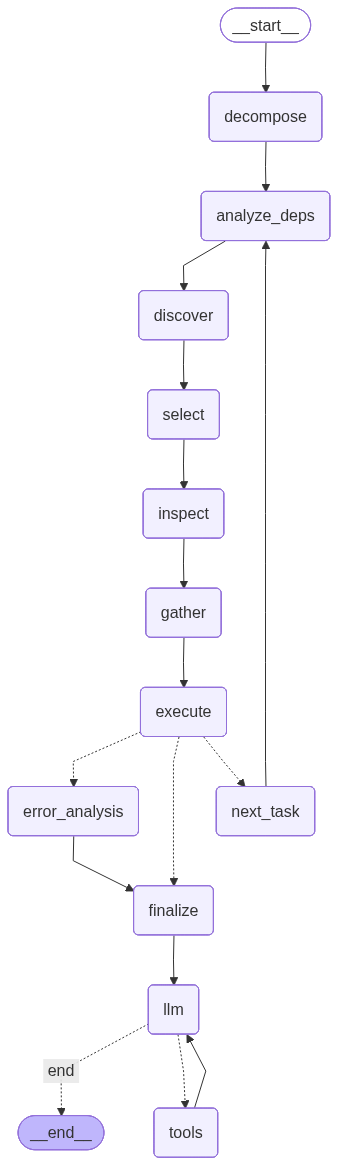

In [6]:
# create the graph using build_multi_step_processing_graph(llm)
from IPython.display import Image, display
mg = build_multi_step_processing_graph(None)
mg = mg.compile()
display(Image(mg.get_graph().draw_mermaid_png()))